<a href="https://colab.research.google.com/github/sanjoy-kumar/Practical-Machine-Learning-Labs/blob/main/Neural_Networks_Project_CNN_Covid_19_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Import required libraries**
------------------------------


In [ ]:
import os
import cv2
import random
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.image as mpimg
from PIL import Image
from tensorflow import keras
from matplotlib import pyplot as plt
from tensorflow.python.keras.layers import *
from tensorflow.python.keras.models import * 
from tensorflow.python.keras.preprocessing import image
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from numpy.random import seed
seed(10)
tf.random.set_seed(10)
%matplotlib inline

**Plot six random images from the train folder**
-------------------------------------------



/content/drive/MyDrive/Covid19DataSets/train/PNEUMONIA/C6EA0BE5-B01E-4113-B194-18D956675E25.jpeg
/content/drive/MyDrive/Covid19DataSets/train/PNEUMONIA/covid-19-pneumonia-15-PA.jpg
/content/drive/MyDrive/Covid19DataSets/train/PNEUMONIA/nejmoa2001191_f3-PA.jpeg
/content/drive/MyDrive/Covid19DataSets/train/PNEUMONIA/41591_2020_819_Fig1_HTML.webp-day5.png
/content/drive/MyDrive/Covid19DataSets/train/NORMAL/IM-0037-0001.jpeg
/content/drive/MyDrive/Covid19DataSets/train/PNEUMONIA/jkms-35-e79-g001-l-c.jpg


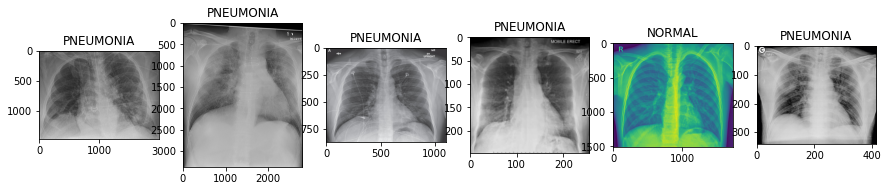

In [ ]:
imagesLocation='/content/drive/MyDrive/Covid19DataSets/train'
plt.figure(figsize=(15,15))
for i in range(6):
 dataLocation = random.choice(os.listdir(imagesLocation))
 dataPath= os.path.join(imagesLocation, dataLocation)
 file=random.choice(os.listdir(dataPath))
 imagePath= os.path.join(dataPath,file)
 print(imagePath)
 img= mpimg.imread(imagePath)
 ax=plt.subplot(1,6,(i+1))
 plt.imshow(img)
 ax.title.set_text(dataLocation)

**Create the dataset**
---------------------


In [ ]:
def createDataset(imgFolder,ImageWidth,ImageHeight):  
    
    imgDataArray=[]
    className=[]
    numImages=0
    for dirName, _, fileNames in os.walk(imgFolder):
        for fileName in fileNames:
            imgPath= os.path.join(dirName, fileName)
            #--------Read the image -----------------------------
            image = cv2.imread(imgPath)
            #------------ BGR is converted to RGB ---------------
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, (ImageWidth,ImageHeight))
            image=np.array(image)
            image = image.astype('float32')
            image /= 255
            imgDataArray.append(image)
            class_=str(dirName).split("/")[-1]
            className.append(class_)
            numImages+=1            
            
    return imgDataArray,className,numImages 

**Load the train and test data**
--------------------------------


In [ ]:
ImageWidth= 224
ImageHeight=224
trainPath='/content/drive/MyDrive/Covid19DataSets/train/'
testPath='/content/drive/MyDrive/Covid19DataSets/test/'
trainImg,trainTarget,numImg=createDataset(trainPath,ImageWidth,ImageHeight)
testImg,testTarget,numTestImg=createDataset(testPath,ImageWidth,ImageHeight)

**Plot six random images**
-----------------------------


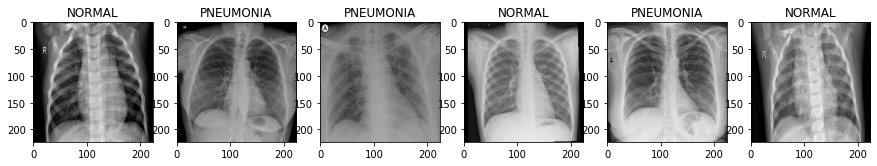

In [ ]:
plt.figure(figsize=(15,15))
for i in range(6):
    randomNum = random.randint(0,numImg)
    ax=plt.subplot(1,6,(i+1))
    plt.imshow(trainImg[randomNum])
    ax.title.set_text(trainTarget[randomNum])

**Convert text labels to numeric codes**
---------------------------------------


In [ ]:
targetDict={k: v for v, k in enumerate(np.unique(trainTarget))}
print(targetDict)
trainTarget= [targetDict[trainTarget[i]] for i in range(len(trainTarget))]
trainTarget=np.array(trainTarget)
trainImg=np.array(trainImg)
testTarget= [targetDict[testTarget[i]] for i in range(len(testTarget))]
testTarget=np.array(testTarget)
testImg=np.array(testImg)


{'NORMAL': 0, 'PNEUMONIA': 1}


**Define the model**
-------------------


In [ ]:
#---------------Saving best model-------------------------------------------------------------------
modelChkPt = ModelCheckpoint('best_mod.h5', save_best_only=True, monitor='accuracy')

#----------------Early stopping for preventing overfitting-------------------------------------------
earlyStop = EarlyStopping(monitor='loss', restore_best_weights=False, patience=10)

#-----------------Define a Sequential() model---------------------------------------------------------
model = Sequential()

#-----------------Add the first layer: 32 is the number of filters; kernel_size (3,3)----------------

model.add(Conv2D(32, kernel_size=(3,3), activation="relu",input_shape=(ImageWidth,ImageHeight,3)))

#---------------- Second layer: specified 64 filters(must be a power of 2)---------------------------
model.add(Conv2D(64, kernel_size=(3,3), activation="relu"))

#-----------------Deine a Max pooling: kernel_size (2,2)---------------------------------------------
model.add(MaxPooling2D(pool_size=(2,2)))

#------------------ Dropout: This prevents the model from overfitting. ------------------------------
model.add(Dropout(0.25))

#------------------ Repeate the above steps to make a deeper network.--------------------------------
model.add(Conv2D(128, kernel_size=(3,3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

#------------------ Flatten layer --------------------------------------------------------------------
model.add(Flatten())
model.add(Dense(64, activation = "relu"))
model.add(Dropout(0.50))

#------------------ Create an output sigmoid function ----------------------------------------------
model.add(Dense(1, activation="sigmoid"))

#------------------- Compile the model: binary_crossentropy(binary classification); adam(optimizer); the metric(accuracy).------------
model.compile(loss="binary_crossentropy", optimizer="adam",metrics = ["accuracy"])

#------------------- Printe the model architecture---------------------------------------------------
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 220, 220, 64)      18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 110, 110, 64)      0         
_________________________________________________________________
dropout (Dropout)            (None, 110, 110, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 108, 108, 128)     73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 128)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 54, 54, 128)       0

**Run the model**
-----------------


In [ ]:
history = model.fit(trainImg, trainTarget, 
          validation_split=0.10, 
          epochs=20, 
          batch_size=32, 
          shuffle=True, 
          callbacks=[modelChkPt, earlyStop]
        )

Epoch 1/20
5/5 [==============================] - 43s 8s/step - loss: 4.4307 - accuracy: 0.4737 - val_loss: 0.7516 - val_accuracy: 0.0000e+00
Epoch 2/20
5/5 [==============================] - 40s 8s/step - loss: 0.6848 - accuracy: 0.6015 - val_loss: 0.5901 - val_accuracy: 1.0000
Epoch 3/20
5/5 [==============================] - 40s 8s/step - loss: 0.6931 - accuracy: 0.5639 - val_loss: 0.6688 - val_accuracy: 0.8000
Epoch 4/20
5/5 [==============================] - 39s 8s/step - loss: 0.5566 - accuracy: 0.7218 - val_loss: 0.5018 - val_accuracy: 0.9333
Epoch 5/20
5/5 [==============================] - 39s 8s/step - loss: 0.4316 - accuracy: 0.8271 - val_loss: 0.2851 - val_accuracy: 0.9333
Epoch 6/20
5/5 [==============================] - 39s 8s/step - loss: 0.2930 - accuracy: 0.8872 - val_loss: 0.4900 - val_accuracy: 0.7333
Epoch 7/20
5/5 [==============================] - 39s 7s/step - loss: 0.4276 - accuracy: 0.8120 - val_loss: 0.1885 - val_accuracy: 1.0000
Epoch 8/20
5/5 [==============

**Plot the loss function and accuracy, for the train and validation sample**
-------------------------------------------------------


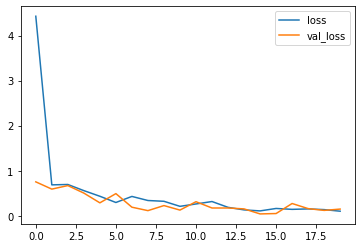

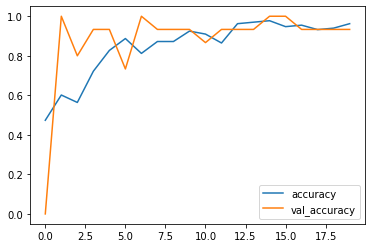

In [ ]:
historyFrame = pd.DataFrame(history.history)
historyFrame.loc[:, ['loss', 'val_loss']].plot()
historyFrame.loc[:, ['accuracy', 'val_accuracy']].plot();

**Predict the results for the test sample**
-------------------------------------------


In [ ]:
#--------------------------Prediction on test set -------------------------------------
pred = model.predict(testImg,batch_size=32)


#--------------------------Performance Evaluation - Accuracy ----------------------

label = [int(p>=0.5) for p in pred]
print ('Accuracy Score : ', accuracy_score(label, testTarget), '\n')

# -------------------------Classification Report, Precision, Recall report --------
print ('Classification Report :\n\n' ,classification_report(label, testTarget))

Accuracy Score :  1.0 

Classification Report :

               precision    recall  f1-score   support

           0       1.00      1.00      1.00        20
           1       1.00      1.00      1.00        20

    accuracy                           1.00        40
   macro avg       1.00      1.00      1.00        40
weighted avg       1.00      1.00      1.00        40

